In [2]:
# Load libraries
library(tidyverse)
library(lubridate)
library(caret)
library(ranger)
library(forcats)
library(stringr)

Warning message:
“package ‘ranger’ was built under R version 3.5.2”

# Load data and combine weather data with crime data

In [3]:
# read data
crime <- read_csv('BPD_Part_1_Victim_Based_Crime_Data.csv') %>% 
         distinct() # get distinct rows of data with no duplicates

Parsed with column specification:
cols(
  CrimeDate = col_character(),
  CrimeTime = col_character(),
  CrimeCode = col_character(),
  Location = col_character(),
  Description = col_character(),
  `Inside/Outside` = col_character(),
  Weapon = col_character(),
  Post = col_integer(),
  District = col_character(),
  Neighborhood = col_character(),
  Longitude = col_double(),
  Latitude = col_double(),
  `Location 1` = col_character(),
  Premise = col_character(),
  crimeCaseNumber = col_character(),
  `Total Incidents` = col_integer()
)


In [4]:
## see how large is the dataset
dim(crime)
sum(is.na(crime$Neighborhood))

[1] 329394     16

[1] 3392

In [5]:
## define look up table for crime types, combine crime type into 6 big categories
lut <- c("COMMON ASSAULT" = "ASSAULT",
         "LARCENY FROM AUTO" = "PROPERTY",
         "AGG. ASSAULT" = "ASSAULT",
         "ROBBERY - STREET" = "ROBBERY",
         "LARCENY" = "PROPERTY",
         "ASSAULT BY THREAT" = "ASSAULT",
         "ROBBERY - CARJACKING" = "ROBBERY",
         "AUTO THEFT" = "PROPERTY",
         "SHOOTING" = "SHOOTING",
         "HOMICIDE" = "HOMICIDE",
         "BURGLARY" = "PROPERTY",
         "ROBBERY - COMMERCIAL" = "ROBBERY",
         "ROBBERY - RESIDENCE" = "ROBBERY",
         "RAPE" = "RAPE",
         "ARSON" = "PROPERTY"
         )

In [6]:
crime$Type <- lut[crime$Description]

In [7]:
##### calculate Month, Year, Day of Month, Hour of crime and Day of weeks for crime
crime <- crime %>% 
  select(CrimeDate,Neighborhood, Longitude, Latitude,  Type) %>% 
  mutate(CrimeDate = mdy(CrimeDate)) %>%  
  filter(!is.na(Type))




In [8]:
## collapse crime count to daily count
crime_daily <- crime %>% 
  group_by(CrimeDate,  Neighborhood, Type) %>% 
  summarize(count = n())
names(crime_daily)[1]='Date'


In [10]:
## prepare the crime dataset to set count to 0 when no certain crime happens
Neighborhood = unique(crime_daily$Neighborhood[!is.na(crime_daily$Neighborhood)])
Type = unique(crime_daily$Type)
Date = seq(ymd('2012-01-01'),ymd('2019-01-12'), by = '1 day')
prepare <- expand.grid(Date = Date,Neighborhood = Neighborhood,Type = Type) %>% 
 mutate(Month = month(Date), Year = year(Date),
         Day = day(Date),  
         Weekday = weekdays(Date, abbreviate=T), Week = week(Date)) %>% 
  mutate(Weekday = factor(Weekday, levels = c("Mon","Tue","Wed","Thu","Fri","Sat","Sun")))
crime_daily <- prepare %>% 
  left_join(crime_daily)
crime_daily$count[is.na(crime_daily$count)] = 0
table(crime_daily$count)


Joining, by = c("Date", "Neighborhood", "Type")
Warning message:
“Column `Neighborhood` joining factor and character vector, coercing into character vector”Warning message:
“Column `Type` joining factor and character vector, coercing into character vector”

Since most of the count is 0, I turn this into a classification problem

In [14]:
crime_daily$Crime = if_else(crime_daily$count == 0, 0, 1)

In [16]:
table(crime_daily$Crime,crime_daily$Type)

   
    ASSAULT HOMICIDE PROPERTY   RAPE ROBBERY SHOOTING
  0  640522   712278   565043 712092  685529   710913
  1   73660     1904   149139   2090   28653     3269

In [17]:
# read weather data
weather <- read_csv('Weather.csv') 


Parsed with column specification:
cols(
  .default = col_character(),
  dt = col_integer(),
  city_id = col_integer(),
  temp = col_double(),
  temp_min = col_double(),
  temp_max = col_double(),
  pressure = col_integer(),
  humidity = col_integer(),
  wind_speed = col_integer(),
  wind_deg = col_integer(),
  rain_1h = col_integer(),
  rain_24h = col_double(),
  rain_today = col_double(),
  clouds_all = col_integer(),
  weather_id = col_integer()
)
See spec(...) for full column specifications.
Warning message in rbind(names(probs), probs_f):
“number of columns of result is not a multiple of vector length (arg 1)”Warning message:
“6721 parsing failures.
row # A tibble: 5 x 5 col     row col     expected               actual file          expected   <int> <chr>   <chr>                  <chr>  <chr>         actual 1  1126 rain_1h no trailing characters .254   'Weather.csv' file 2  2367 rain_1h no trailing characters .016   'Weather.csv' row 3  2776 rain_1h no trailing characters .286   '

In [18]:
weather <- weather %>% 
  select(dt_iso,temp,temp_min,temp_max,pressure,humidity,wind_speed,clouds_all, weather_description) %>% 
  mutate(count = 1, weather_description = str_replace_all(weather_description,' ','_')) %>% 
  mutate(DateTime = ymd_hms(dt_iso,tz = "America/New_York"), Date = date(DateTime)) %>% 
  distinct(dt_iso,.keep_all = T) %>% 
  spread(weather_description, count, fill = 0) %>% 
  select(-dt_iso)

Date in ISO8601 format; converting timezone from UTC to "America/New_York".


In [19]:
weather_daily <- weather %>% 
  group_by(Date) %>% 
  summarize(temp = mean(temp, na.rm = T), temp_min = min(temp_min,na.rm = T), temp_max = max(temp_max),
           pressure = mean(pressure, na.rm = T), humidity = mean(humidity, na.rm = T), wind_speed = max(wind_speed, na.rm  = T),
           clouds_all = mean(clouds_all,na.rm=T),broken_clouds=sum(broken_clouds),drizzle = sum(drizzle),
           few_clouds = sum(few_clouds), fog=sum(fog), freezing_rain = sum(freezing_rain),haze=sum(haze),
           heavy_intensity_drizzle = sum(heavy_intensity_drizzle),heavy_intensity_rain=sum(heavy_intensity_rain),
           heavy_intensity_shower_rain=sum(heavy_intensity_shower_rain),heavy_snow=sum(heavy_snow),
           light_intensity_drizzle=sum(light_intensity_drizzle),light_intensity_shower_rain=sum(light_intensity_shower_rain),
           light_rain=sum(light_rain),light_rain_and_snow=sum(light_rain_and_snow),light_shower_snow=sum(light_shower_snow),
           light_snow=sum(light_snow),mist=sum(mist),moderate_rain=sum(moderate_rain),overcast_clouds=sum(overcast_clouds),
           proximity_shower_rain=sum(proximity_shower_rain),proximity_thunderstorm=sum(proximity_thunderstorm),
           proximity_thunderstorm_with_rain=sum(proximity_thunderstorm_with_rain),scattered_clouds=sum(scattered_clouds),
           shower_rain=sum(shower_rain),shower_snow=sum(shower_snow),sky_is_clear=sum(sky_is_clear+Sky_is_Clear),
           smoke=sum(smoke),snow=sum(snow),SQUALLS=sum(SQUALLS),thunderstorm=sum(thunderstorm),
           thunderstorm_with_heavy_rain=sum(thunderstorm_with_heavy_rain),thunderstorm_with_light_drizzle=sum(thunderstorm_with_light_drizzle),
           thunderstorm_with_light_rain=sum(thunderstorm_with_light_rain),thunderstorm_with_rain=sum(thunderstorm_with_rain),
           very_heavy_rain=sum(very_heavy_rain))

In [20]:
weather_crime_daily <- crime_daily %>% 
 left_join(weather_daily) %>% 
 filter(!is.na(temp))

Joining, by = "Date"


[1] 0

'data.frame':	3275952 obs. of  52 variables:
 $ Date                            : Date, format: "2012-10-01" "2012-10-02" ...
 $ Neighborhood                    : chr  "Abell" "Abell" "Abell" "Abell" ...
 $ Type                            : chr  "PROPERTY" "PROPERTY" "PROPERTY" "PROPERTY" ...
 $ Month                           : num  10 10 10 10 10 10 10 10 10 10 ...
 $ Year                            : num  2012 2012 2012 2012 2012 ...
 $ Day                             : int  1 2 3 4 5 6 7 8 9 10 ...
 $ Weekday                         : Factor w/ 7 levels "Mon","Tue","Wed",..: 1 2 3 4 5 6 7 1 2 3 ...
 $ Week                            : num  40 40 40 40 40 40 41 41 41 41 ...
 $ count                           : num  1 0 0 0 0 0 0 0 0 0 ...
 $ Crime                           : num  1 0 0 0 0 0 0 0 0 0 ...
 $ temp                            : num  285 292 292 296 296 ...
 $ temp_min                        : num  283 285 288 291 288 ...
 $ temp_max                        : num  290 297 

# Exploratory Data Analysis

In [21]:
weather_crime_daily$Month = factor(weather_crime_daily$Month)
weather_crime_daily$Day = factor(weather_crime_daily$Day)
names(weather_crime_daily)

[1] "Date"                             "Neighborhood"                    
 [3] "Type"                             "Month"                           
 [5] "Year"                             "Day"                             
 [7] "Weekday"                          "Week"                            
 [9] "count"                            "Crime"                           
[11] "temp"                             "temp_min"                        
[13] "temp_max"                         "pressure"                        
[15] "humidity"                         "wind_speed"                      
[17] "clouds_all"                       "broken_clouds"                   
[19] "drizzle"                          "few_clouds"                      
[21] "fog"                              "freezing_rain"                   
[23] "haze"                             "heavy_intensity_drizzle"         
[25] "heavy_intensity_rain"             "heavy_intensity_shower_rain"     
[27] "heavy_snow"                       "light_intensity_drizzle"         
[29] "light_intensity_shower_rain"      "light_rain"                      
[31] "light_rain_and_snow"              "light_shower_snow"               
[33] "light_snow"                       "mist"                            
[35] "moderate_rain"                    "overcast_clouds"                 
[37] "proximity_shower_rain"            "proximity_thunderstorm"          
[39] "proximity_thunderstorm_with_rain" "scattered_clouds"                
[41] "shower_rain"                      "shower_snow"                     
[43] "sky_is_clear"                     "smoke"                           
[45] "snow"                             "SQUALLS"                         
[47] "thunderstorm"                     "thunderstorm_with_heavy_rain"    
[49] "thunderstorm_with_light_drizzle"  "thunderstorm_with_light_rain"    
[51] "thunderstorm_with_rain"           "very_heavy_rain"

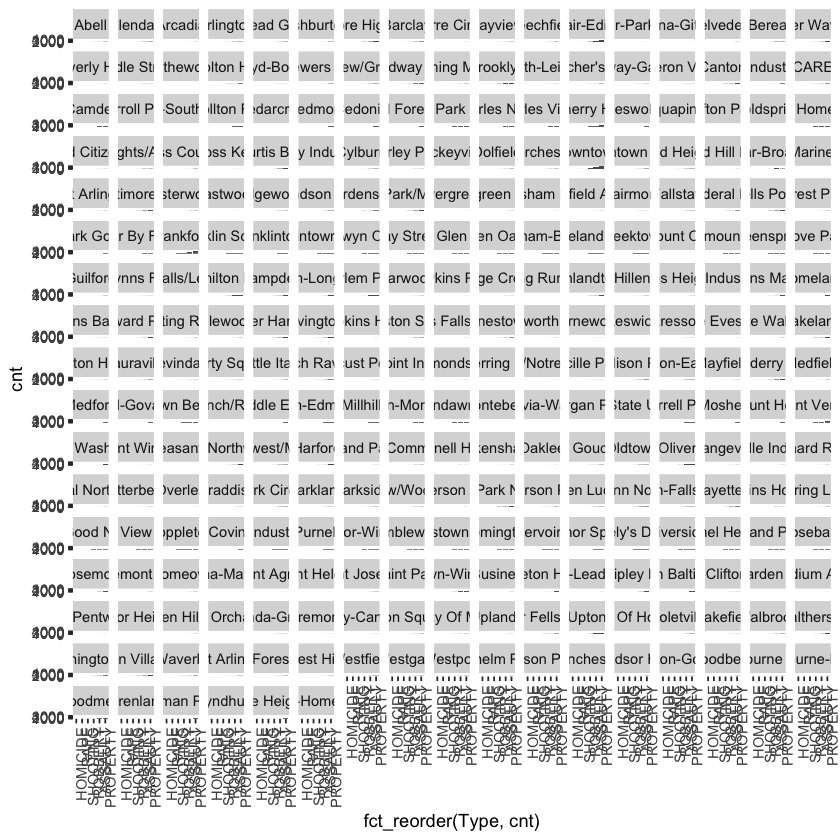

In [23]:
##### crime by type
weather_crime_daily %>% 
 group_by(Type,Neighborhood) %>% 
 summarize(cnt = sum(count)) %>% 
ggplot(aes(fct_reorder(Type,cnt),cnt))  +
geom_bar(stat='identity') +
facet_wrap(~Neighborhood)+
theme(axis.text.x = element_text(angle = 90, hjust = 1))

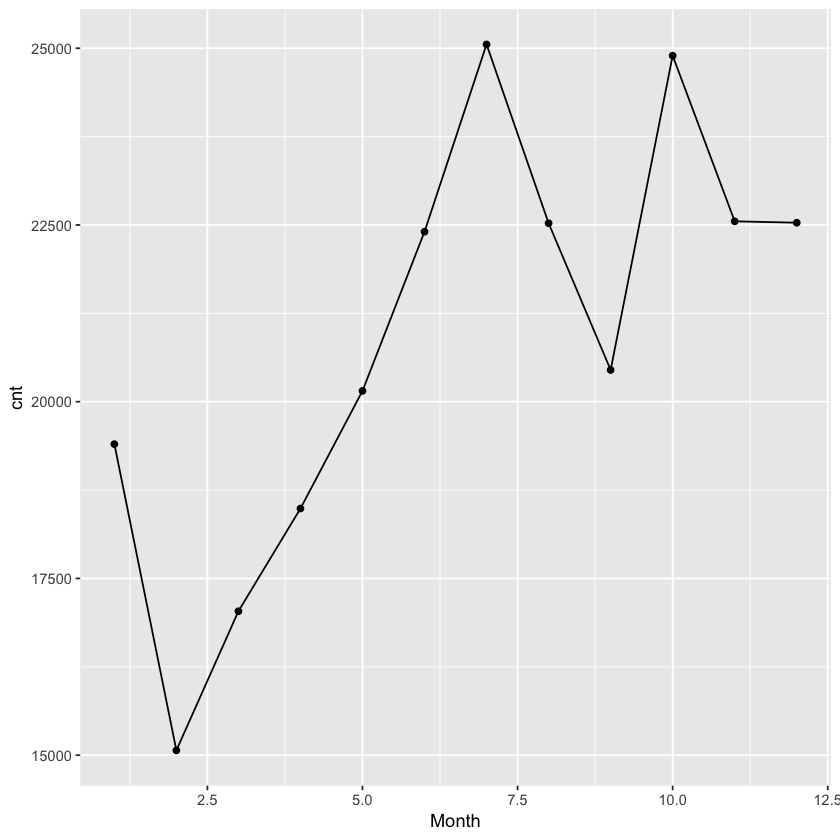

In [29]:
#Crime by Month
weather_crime_daily %>% 
 group_by(Month) %>% 
 summarize(cnt = sum(count)) %>% 
 mutate(Month = as.numeric(Month)) %>% 
ggplot(aes(x=Month, y = cnt))  +
geom_point() +
geom_line()


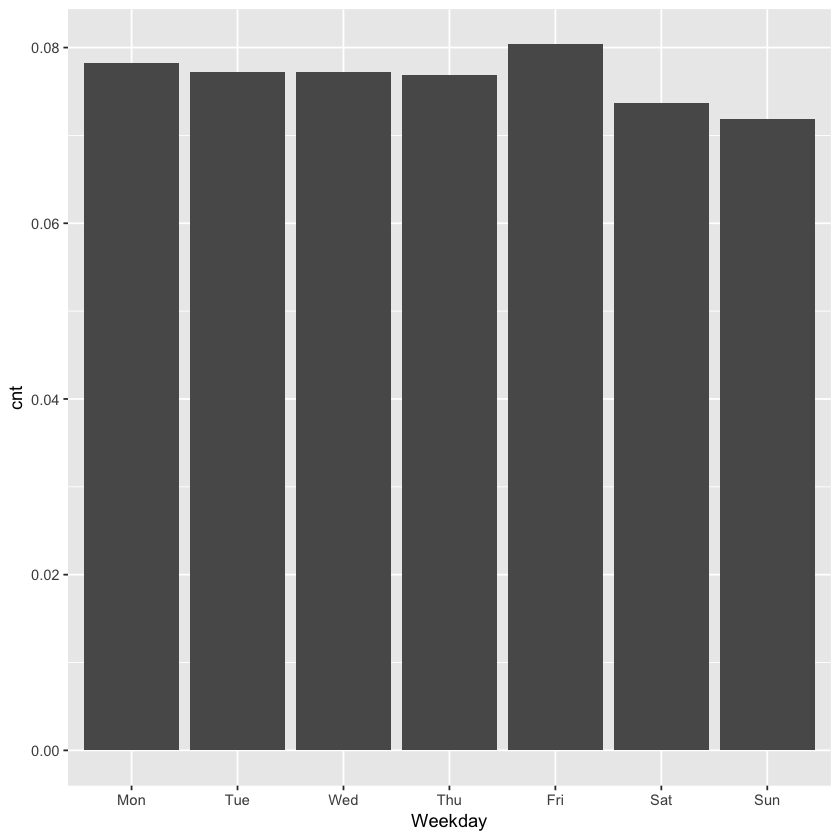

In [30]:
#Crime by Weekday
weather_crime_daily %>% 
 group_by(Weekday) %>% 
 summarize(cnt = mean(count)) %>% 
ggplot(aes(x=Weekday, y = cnt))  +
geom_bar(stat='identity') 




# Model building


Since every type of crime differs a lot in terms of counts, it's better to model different types of crime separately, let's first try model property crime


In [31]:
train_property <- weather_crime_daily %>% filter(Date <ymd(20181001),Type == 'PROPERTY')

In [32]:
test_property <- weather_crime_daily %>% filter(Date >= ymd(20181001),Type == 'PROPERTY')
names(weather_crime_daily)

[1] "Date"                             "Neighborhood"                    
 [3] "Type"                             "Month"                           
 [5] "Year"                             "Day"                             
 [7] "Weekday"                          "Week"                            
 [9] "count"                            "Crime"                           
[11] "temp"                             "temp_min"                        
[13] "temp_max"                         "pressure"                        
[15] "humidity"                         "wind_speed"                      
[17] "clouds_all"                       "broken_clouds"                   
[19] "drizzle"                          "few_clouds"                      
[21] "fog"                              "freezing_rain"                   
[23] "haze"                             "heavy_intensity_drizzle"         
[25] "heavy_intensity_rain"             "heavy_intensity_shower_rain"     
[27] "heavy_snow"                       "light_intensity_drizzle"         
[29] "light_intensity_shower_rain"      "light_rain"                      
[31] "light_rain_and_snow"              "light_shower_snow"               
[33] "light_snow"                       "mist"                            
[35] "moderate_rain"                    "overcast_clouds"                 
[37] "proximity_shower_rain"            "proximity_thunderstorm"          
[39] "proximity_thunderstorm_with_rain" "scattered_clouds"                
[41] "shower_rain"                      "shower_snow"                     
[43] "sky_is_clear"                     "smoke"                           
[45] "snow"                             "SQUALLS"                         
[47] "thunderstorm"                     "thunderstorm_with_heavy_rain"    
[49] "thunderstorm_with_light_drizzle"  "thunderstorm_with_light_rain"    
[51] "thunderstorm_with_rain"           "very_heavy_rain"

ERROR: Error in `contrasts<-`(`*tmp*`, value = contr.funs[1 + isOF[nn]]): contrasts can be applied only to factors with 2 or more levels


ERROR: Error in summary(poisson_model): object 'poisson_model' not found


ERROR: Error in predict(poisson_model, test_property): object 'poisson_model' not found


ERROR: Error in xy.coords(x, y, xlabel, ylabel, log): 'x' and 'y' lengths differ


In [1]:
rf_model1 = ranger(Crime~.-count-Year-Type-Week-Date,data = train_property,num.trees = 500)

ERROR: Error in ranger(Crime ~ . - count - Year - Type - Week - Date, data = train_property, : could not find function "ranger"


In [25]:
rf_model2 = ranger(count~District+Day+Month+Weekday+temp+humidity+wind_speed,data = train_property,num.trees = 500)

In [26]:
test_property$pred_rf1 = predict(rf_model1,test_property)$predictions
test_property$pred_rf2 = predict(rf_model2,test_property)$predictions

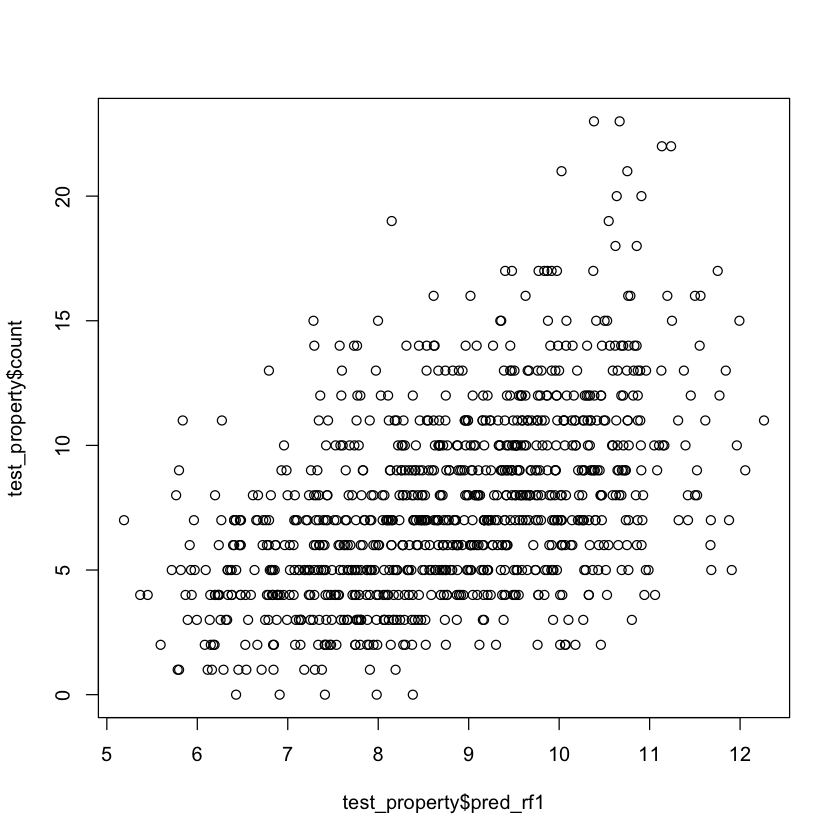

In [27]:
plot(test_property$pred_rf1,test_property$count)

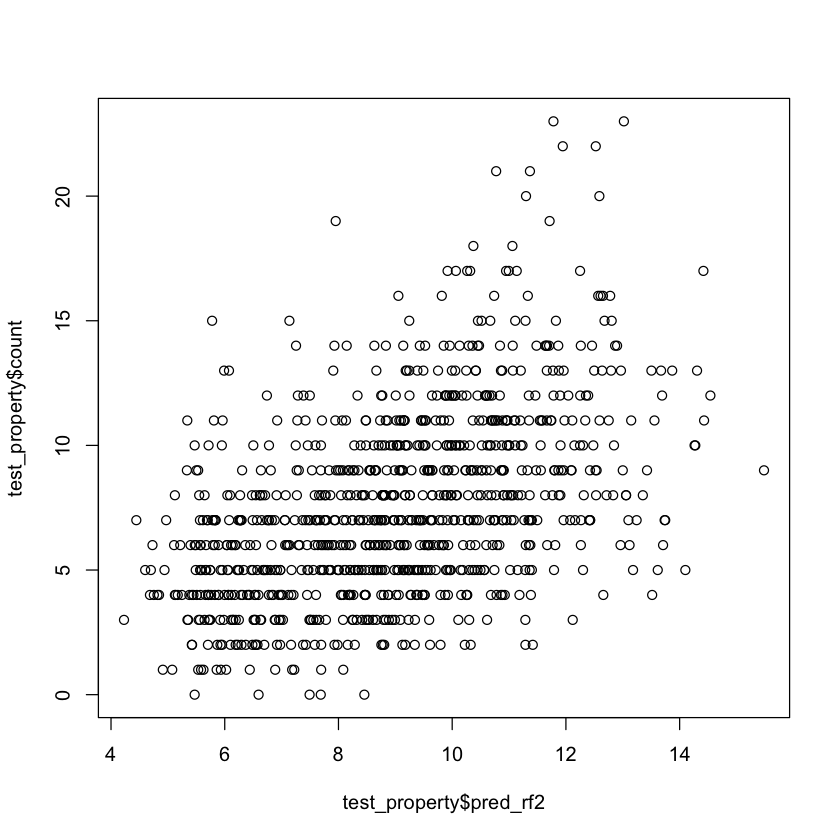

In [28]:
plot(test_property$pred_rf2,test_property$count)

In [29]:
length(names(weather_crime_daily))

[1] 51

In [30]:
pr = prcomp(weather_crime_daily[,17:51],scale = T,center = T)

In [31]:
pr.var = pr$sdev^2

In [32]:
pve = pr.var/sum(pr.var)

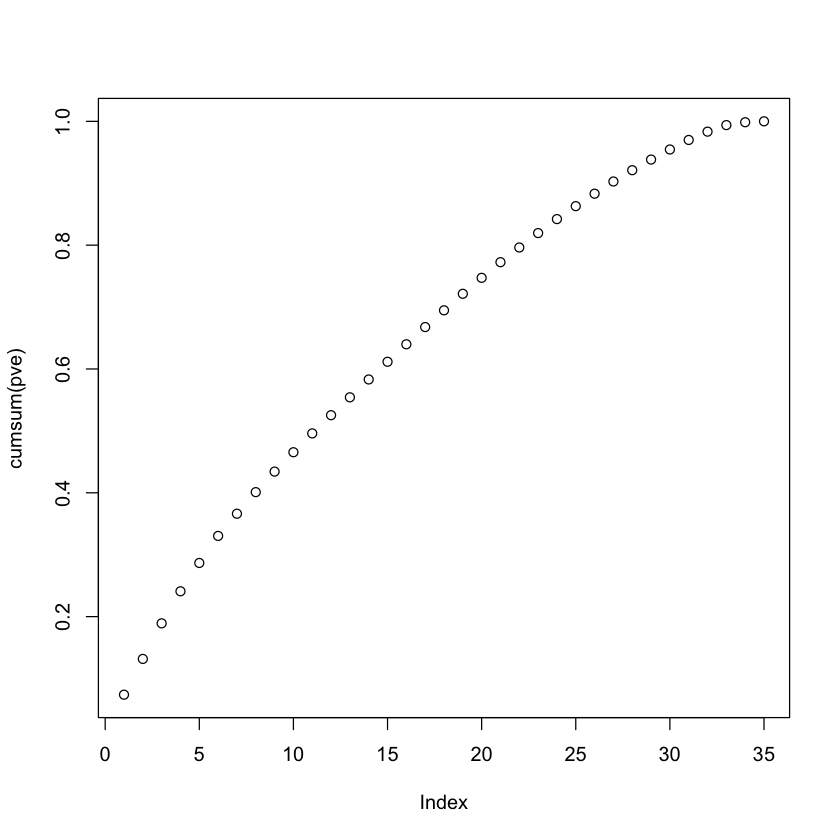

In [34]:
plot(cumsum(pve))